## Flair_NER_Training

Jay Urbain, PhD   
jay.urbain@gmail.com

Working example of building a named entity recognition model from your own training data with different pretrained embeddings using the Flair NLP library. 

*Note: Flair offers several corpi that you can download into their Corpus object, but the documentation does not provide an example of how to create a Corpus from your own annotated training data. This notebook, hopefully helps with this.*


Flair from Zalando research offers current state-of-the-art named entity recognition algorithms along with word, character and contextual (Elmo, Bert) pretrained emeddings:  
https://github.com/flairNLP/flair


Named entity dataset:  
https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus        
        

### Create train, development, and test files for Flair

Use ner_dataset.csv

In [213]:
from flair.data import Corpus
from flair.datasets import ColumnCorpus

filepath = '/Users/jayurbain/Dropbox/SearchStreetNames/entity-annotated-corpus/ner_dataset.csv'


In [169]:
import pandas as pd

df = pd.read_csv(filepath, encoding = "latin")

In [170]:
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [171]:
df = df.drop('Sentence #', 1)
df

,Word,POS,Tag
0,Thousands,NNS,O
1,of,IN,O
2,demonstrators,NNS,O
3,have,VBP,O
4,marched,VBN,O
...,...,...,...
1048570,they,PRP,O
1048571,responded,VBD,O
1048572,to,TO,O
1048573,the,DT,O


In [172]:
# df.insert(0, 'Id', df.index)
# df

In [173]:
df.shape

(1048575, 3)

In [174]:
df_train = df.iloc[:7000]
df_dev = df.iloc[7000:8000]
df_test = df.iloc[8000:10000]

In [175]:
#columns=['Id', Word', 'POS', 'Tag']
# columns = {0: 'idx', 1: 'text', 2: 'pos', 3: 'ner'}
columns = ['text', 'pos', 'ner']

df.to_csv('ner_dataset_proc.csv', index=False, header=columns)

df_train.to_csv('ner_dataset_proc_train.csv', index=False, header=False)
df_dev.to_csv('ner_dataset_proc_dev.csv', index=False, header=False)
df_test.to_csv('ner_dataset_proc_test.csv', index=False, header=False)

In [176]:
!pwd

/Users/jayurbain/Dropbox/SearchStreetNames/SearchStreetNames


In [177]:
#!cat ner_dataset_proc_train.csv


In [178]:
df_train = pd.read_csv('ner_dataset_proc_train.csv', names=columns)
df_dev = pd.read_csv('ner_dataset_proc_dev.csv', names=columns)
df_test = pd.read_csv('ner_dataset_proc_test.csv', names=columns)

In [179]:
df_test.head()

,text,pos,ner
0,.,.,O
1,The,DT,O
2,deal,NN,O
3,is,VBZ,O
4,one,CD,O


In [180]:
train_corpus_file = 'ner_dataset_proc_corpus_train.csv'
dev_corpus_file = 'ner_dataset_proc_corpus_dev.csv'
test_corpus_file = 'ner_dataset_proc_corpus_test.csv'

In [181]:
with open(train_corpus_file, "w") as f:
    idx=1
    for index, row in df_train.iterrows():
        print(idx, row['text'], row['pos'], row['ner'], sep='\t', file=f)
        idx += 1
        if row['text']=='.' and  row['pos']=='.' and row['ner']=='O':
            print(file=f)
            idx=1

In [182]:
with open(dev_corpus_file, "w") as f:
    idx=1
    for index, row in df_dev.iterrows():
        print(idx, row['text'], row['pos'], row['ner'], sep='\t', file=f)
        idx += 1
        if row['text']=='.' and  row['pos']=='.' and row['ner']=='O':
            print(file=f)
            idx=1

In [183]:
with open(test_corpus_file, "w") as f:
    idx=1
    for index, row in df_test.iterrows():
        print(idx, row['text'], row['pos'], row['ner'], sep='\t', file=f)
        idx += 1
        if row['text']=='.' and  row['pos']=='.' and row['ner']=='O':
            print(file=f)
            idx=1

In [184]:
from flair.data import Corpus
from flair.datasets import ColumnCorpus

# define columns
columns = {0: 'idx', 1: 'text', 2: 'pos', 3: 'ner'}

# this is the folder in which train, test and dev files reside
data_folder = './'

# init a corpus using column format, data folder and the names of the train, dev and test files
corpus: Corpus = ColumnCorpus(data_folder, columns,
                              train_file=train_corpus_file,
                              dev_file=dev_corpus_file,
                              test_file=test_corpus_file)
    

2020-02-16 09:58:51,769 Reading data from .
2020-02-16 09:58:51,770 Train: ner_dataset_proc_corpus_train.csv
2020-02-16 09:58:51,772 Dev: ner_dataset_proc_corpus_dev.csv
2020-02-16 09:58:51,773 Test: ner_dataset_proc_corpus_test.csv


In [185]:
from flair.data import Corpus
from flair.datasets import WNUT_17
from flair.embeddings import TokenEmbeddings, WordEmbeddings, StackedEmbeddings, CharacterEmbeddings, FlairEmbeddings
from typing import List

from flair.data import Sentence
from flair.models import SequenceTagger

# 1. get the corpus
# corpus: Corpus = WNUT_17().downsample(0.1)
# print(corpus)

### Documentation on Flair sequence labeling file format

In [186]:
!pwd

/Users/jayurbain/Dropbox/SearchStreetNames/SearchStreetNames


In [187]:
!head 'ner_dataset_proc_corpus_train.csv'


1	Thousands	NNS	O
2	of	IN	O
3	demonstrators	NNS	O
4	have	VBP	O
5	marched	VBN	O
6	through	IN	O
7	London	NNP	B-geo
8	to	TO	O
9	protest	VB	O
10	the	DT	O


### Very small example (2 training sentences) under resources in Flair repo

In [188]:
!head '/Users/jayurbain/Dropbox/SearchStreetNames/flair/tests/resources/tasks/germeval/NER-de-train.tsv'


#	n-tv.de vom 26.02.2005	[2005-02-26]
1	Schartau	B-PER	O
2	sagte	O	O
3	dem	O	O
4	"	O	O
5	Tagesspiegel	B-ORG	O
6	"	O	O
7	vom	O	O
8	Freitag	O	O
9	,	O	O


In [189]:
from flair.data import Corpus
from flair.datasets import ColumnCorpus

# # # 1. create corpus

# # define columns
# columns = {0: 'idx', 1: 'text', 2: 'ner', 3: 'ner_nested'}

# # this is the folder in which train, test and dev files reside
# data_folder = '/Users/jayurbain/Dropbox/SearchStreetNames/flair/tests/resources/tasks/germeval'

# # init a corpus using column format, data folder and the names of the train, dev and test files
# corpus: Corpus = ColumnCorpus(data_folder, columns,
#                               train_file='NER-de-train.tsv',
#                               test_file='NER-de-test.tsv',
#                               dev_file='NER-de-dev.tsv')

In [190]:
corpus

In [191]:
stats = corpus.obtain_statistics()
print(stats)

{
    "TRAIN": {
        "dataset": "TRAIN",
        "total_number_of_documents": 319,
        "number_of_documents_per_class": {},
        "number_of_tokens_per_tag": {},
        "number_of_tokens": {
            "total": 7000,
            "min": 4,
            "max": 41,
            "avg": 21.9435736677116
        }
    },
    "TEST": {
        "dataset": "TEST",
        "total_number_of_documents": 91,
        "number_of_documents_per_class": {},
        "number_of_tokens_per_tag": {},
        "number_of_tokens": {
            "total": 2000,
            "min": 1,
            "max": 59,
            "avg": 21.978021978021978
        }
    },
    "DEV": {
        "dataset": "DEV",
        "total_number_of_documents": 48,
        "number_of_documents_per_class": {},
        "number_of_tokens_per_tag": {},
        "number_of_tokens": {
            "total": 1000,
            "min": 4,
            "max": 46,
            "avg": 20.833333333333332
        }
    }
}


In [192]:
print(corpus.train[0].to_tagged_string('ner'))
# print(corpus.train[1].to_tagged_string('pos'))

Thousands of demonstrators have marched through London <B-geo> to protest the war in Iraq <B-geo> and demand the withdrawal of British <B-gpe> troops from that country .


In [193]:
# print the number of Sentences in the train split
print(len(corpus.train))

# print the number of Sentences in the test split
print(len(corpus.test))

# print the number of Sentences in the dev split
print(len(corpus.dev))

319
91
48


In [194]:
#[print( len(sentence) ) for sentence in corpus.train ]

In [195]:
# 1. get the corpus
# corpus: TaggedCorpus = NLPTaskDataFetcher.fetch_data(NLPTask.CONLL_03)
# print(corpus)

# remove empty sentences
# corpus.train = [sentence for sentence in corpus.train if len(sentence) > 0]
# corpus.test = [sentence for sentence in corpus.test if len(sentence) > 0]
# corpus.dev = [sentence for sentence in corpus.dev if len(sentence) > 0]
# print(corpus)

[sentence for sentence in corpus.train if len(sentence) == 0]
[sentence for sentence in corpus.test if len(sentence) == 0]
[sentence for sentence in corpus.dev if len(sentence) == 0]

[]

### Train the model

Dictionary with 21 tags: <unk>, O, B-geo, B-gpe, B-per, I-geo, B-org, I-org, B-tim, B-art, I-art, I-per, I-gpe, I-tim, , B-nat, B-eve, I-eve, I-nat, <START>, <STOP>
2020-02-16 10:28:16,369 ----------------------------------------------------------------------------------------------------
2020-02-16 10:28:16,371 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings('glove')
    (list_embedding_1): CharacterEmbeddings(
      (char_embedding): Embedding(275, 25)
      (char_rnn): LSTM(25, 25, bidirectional=True)
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.25, inplace=False)
        (encoder): Embedding(275, 100)
        (rnn): LSTM(100, 1024)
        (decoder): Linear(in_features=1024, out_features=275, bias=True)
      )
    )
    (list_embedding_3): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.25, inplace=False)
        (encoder): Embedding(275, 100)
        

2020-02-16 10:31:23,855 epoch 5 - iter 4/10 - loss 10.38265276 - samples/sec: 15.31
2020-02-16 10:31:26,211 epoch 5 - iter 5/10 - loss 9.90691452 - samples/sec: 14.09
2020-02-16 10:31:28,549 epoch 5 - iter 6/10 - loss 10.24441830 - samples/sec: 14.41
2020-02-16 10:31:31,216 epoch 5 - iter 7/10 - loss 10.31939275 - samples/sec: 12.44
2020-02-16 10:31:33,856 epoch 5 - iter 8/10 - loss 10.41689718 - samples/sec: 12.66
2020-02-16 10:31:36,500 epoch 5 - iter 9/10 - loss 10.18811819 - samples/sec: 12.56
2020-02-16 10:31:39,223 epoch 5 - iter 10/10 - loss 9.95641303 - samples/sec: 12.24
2020-02-16 10:31:39,351 ----------------------------------------------------------------------------------------------------
2020-02-16 10:31:39,353 EPOCH 5 done: loss 9.9564 - lr 0.1000
2020-02-16 10:31:40,388 DEV : loss 7.356204986572266 - score 0.3898
2020-02-16 10:31:40,403 BAD EPOCHS (no improvement): 0
2020-02-16 10:31:47,270 -------------------------------------------------------------------------------

2020-02-16 10:35:13,298 ----------------------------------------------------------------------------------------------------
2020-02-16 10:35:13,299 EPOCH 11 done: loss 4.2450 - lr 0.1000
2020-02-16 10:35:14,397 DEV : loss 3.8040308952331543 - score 0.6807
2020-02-16 10:35:14,412 BAD EPOCHS (no improvement): 1
2020-02-16 10:35:14,415 ----------------------------------------------------------------------------------------------------
2020-02-16 10:35:17,335 epoch 12 - iter 1/10 - loss 5.63602066 - samples/sec: 10.98
2020-02-16 10:35:20,223 epoch 12 - iter 2/10 - loss 5.39128923 - samples/sec: 11.61
2020-02-16 10:35:23,639 epoch 12 - iter 3/10 - loss 4.95030435 - samples/sec: 9.73
2020-02-16 10:35:26,805 epoch 12 - iter 4/10 - loss 4.79103327 - samples/sec: 10.54
2020-02-16 10:35:30,068 epoch 12 - iter 5/10 - loss 4.54224443 - samples/sec: 10.21
2020-02-16 10:35:33,439 epoch 12 - iter 6/10 - loss 4.35881229 - samples/sec: 9.96
2020-02-16 10:35:36,732 epoch 12 - iter 7/10 - loss 4.0944084

2020-02-16 10:38:12,368 epoch 18 - iter 3/10 - loss 2.37438941 - samples/sec: 16.89
2020-02-16 10:38:14,422 epoch 18 - iter 4/10 - loss 2.57666034 - samples/sec: 16.35
2020-02-16 10:38:16,434 epoch 18 - iter 5/10 - loss 2.53116875 - samples/sec: 16.58
2020-02-16 10:38:18,420 epoch 18 - iter 6/10 - loss 2.56714145 - samples/sec: 16.81
2020-02-16 10:38:20,675 epoch 18 - iter 7/10 - loss 2.72406254 - samples/sec: 14.83
2020-02-16 10:38:22,912 epoch 18 - iter 8/10 - loss 2.79149076 - samples/sec: 14.87
2020-02-16 10:38:25,455 epoch 18 - iter 9/10 - loss 2.70927522 - samples/sec: 13.13
2020-02-16 10:38:28,020 epoch 18 - iter 10/10 - loss 2.79958198 - samples/sec: 12.95
2020-02-16 10:38:28,166 ----------------------------------------------------------------------------------------------------
2020-02-16 10:38:28,170 EPOCH 18 done: loss 2.7996 - lr 0.1000
2020-02-16 10:38:29,212 DEV : loss 2.7730140686035156 - score 0.7373
2020-02-16 10:38:29,228 BAD EPOCHS (no improvement): 0
2020-02-16 10:3

2020-02-16 10:41:01,210 epoch 24 - iter 9/10 - loss 2.03919019 - samples/sec: 20.23
2020-02-16 10:41:03,014 epoch 24 - iter 10/10 - loss 1.96379225 - samples/sec: 18.53
2020-02-16 10:41:03,085 ----------------------------------------------------------------------------------------------------
2020-02-16 10:41:03,087 EPOCH 24 done: loss 1.9638 - lr 0.0500
2020-02-16 10:41:03,712 DEV : loss 2.7344717979431152 - score 0.7521
2020-02-16 10:41:03,721 BAD EPOCHS (no improvement): 0
2020-02-16 10:41:08,221 ----------------------------------------------------------------------------------------------------
2020-02-16 10:41:09,892 epoch 25 - iter 1/10 - loss 1.83977008 - samples/sec: 19.17
2020-02-16 10:41:11,669 epoch 25 - iter 2/10 - loss 2.35084581 - samples/sec: 18.85
2020-02-16 10:41:13,332 epoch 25 - iter 3/10 - loss 2.29900861 - samples/sec: 20.13
2020-02-16 10:41:15,201 epoch 25 - iter 4/10 - loss 2.11894691 - samples/sec: 17.82
2020-02-16 10:41:16,909 epoch 25 - iter 5/10 - loss 1.9996

2020-02-16 10:43:25,792 ----------------------------------------------------------------------------------------------------
2020-02-16 10:43:27,625 epoch 31 - iter 1/10 - loss 1.50946546 - samples/sec: 17.48
2020-02-16 10:43:29,737 epoch 31 - iter 2/10 - loss 1.49714577 - samples/sec: 15.73
2020-02-16 10:43:31,621 epoch 31 - iter 3/10 - loss 1.60022902 - samples/sec: 17.81
2020-02-16 10:43:33,731 epoch 31 - iter 4/10 - loss 1.60942382 - samples/sec: 15.82
2020-02-16 10:43:35,891 epoch 31 - iter 5/10 - loss 1.51994944 - samples/sec: 15.46
2020-02-16 10:43:38,065 epoch 31 - iter 6/10 - loss 1.65912600 - samples/sec: 15.35
2020-02-16 10:43:40,304 epoch 31 - iter 7/10 - loss 1.56940389 - samples/sec: 15.03
2020-02-16 10:43:42,426 epoch 31 - iter 8/10 - loss 1.59664482 - samples/sec: 15.80
2020-02-16 10:43:44,905 epoch 31 - iter 9/10 - loss 1.59769583 - samples/sec: 13.53
2020-02-16 10:43:47,179 epoch 31 - iter 10/10 - loss 1.68650005 - samples/sec: 14.74
2020-02-16 10:43:47,293 ----------

2020-02-16 10:45:39,663 epoch 37 - iter 5/10 - loss 1.53416698 - samples/sec: 14.01
2020-02-16 10:45:41,831 epoch 37 - iter 6/10 - loss 1.42967786 - samples/sec: 15.49
2020-02-16 10:45:44,138 epoch 37 - iter 7/10 - loss 1.33732746 - samples/sec: 14.59
2020-02-16 10:45:46,751 epoch 37 - iter 8/10 - loss 1.41221289 - samples/sec: 12.78
2020-02-16 10:45:48,990 epoch 37 - iter 9/10 - loss 1.42167593 - samples/sec: 15.00
2020-02-16 10:45:51,224 epoch 37 - iter 10/10 - loss 1.37945926 - samples/sec: 15.01
2020-02-16 10:45:51,339 ----------------------------------------------------------------------------------------------------
2020-02-16 10:45:51,340 EPOCH 37 done: loss 1.3795 - lr 0.0063
2020-02-16 10:45:52,119 DEV : loss 2.190838098526001 - score 0.75
2020-02-16 10:45:52,131 BAD EPOCHS (no improvement): 1
2020-02-16 10:45:52,133 ----------------------------------------------------------------------------------------------------
2020-02-16 10:45:54,297 epoch 38 - iter 1/10 - loss 1.0117287

2020-02-16 10:48:01,571 ----------------------------------------------------------------------------------------------------
2020-02-16 10:48:01,573 EPOCH 43 done: loss 1.3926 - lr 0.0031
2020-02-16 10:48:02,347 DEV : loss 2.2359540462493896 - score 0.75
2020-02-16 10:48:02,359 BAD EPOCHS (no improvement): 3
2020-02-16 10:48:02,361 ----------------------------------------------------------------------------------------------------
2020-02-16 10:48:04,430 epoch 44 - iter 1/10 - loss 1.42470098 - samples/sec: 15.49
2020-02-16 10:48:06,566 epoch 44 - iter 2/10 - loss 1.28947508 - samples/sec: 15.64
2020-02-16 10:48:08,430 epoch 44 - iter 3/10 - loss 1.24652878 - samples/sec: 17.99
2020-02-16 10:48:10,273 epoch 44 - iter 4/10 - loss 1.27450472 - samples/sec: 18.16
2020-02-16 10:48:12,137 epoch 44 - iter 5/10 - loss 1.35806208 - samples/sec: 17.94
2020-02-16 10:48:16,353 epoch 44 - iter 6/10 - loss 1.32907506 - samples/sec: 7.75
2020-02-16 10:48:18,382 epoch 44 - iter 7/10 - loss 1.29904577

2020-02-16 10:50:14,174 epoch 50 - iter 1/10 - loss 0.46905899 - samples/sec: 17.15
2020-02-16 10:50:16,502 epoch 50 - iter 2/10 - loss 1.21574128 - samples/sec: 14.31
2020-02-16 10:50:18,522 epoch 50 - iter 3/10 - loss 1.25947738 - samples/sec: 16.54
2020-02-16 10:50:20,590 epoch 50 - iter 4/10 - loss 1.40944570 - samples/sec: 16.21
2020-02-16 10:50:22,552 epoch 50 - iter 5/10 - loss 1.38229866 - samples/sec: 17.03
2020-02-16 10:50:24,575 epoch 50 - iter 6/10 - loss 1.40567360 - samples/sec: 16.48
2020-02-16 10:50:26,674 epoch 50 - iter 7/10 - loss 1.40077804 - samples/sec: 15.85
2020-02-16 10:50:28,743 epoch 50 - iter 8/10 - loss 1.43398468 - samples/sec: 16.10
2020-02-16 10:50:30,655 epoch 50 - iter 9/10 - loss 1.42131227 - samples/sec: 17.46
2020-02-16 10:50:32,664 epoch 50 - iter 10/10 - loss 1.35763861 - samples/sec: 16.62
2020-02-16 10:50:32,747 ----------------------------------------------------------------------------------------------------
2020-02-16 10:50:32,748 EPOCH 50 d

2020-02-16 10:52:41,242 epoch 56 - iter 7/10 - loss 1.25130701 - samples/sec: 19.45
2020-02-16 11:11:57,286 epoch 56 - iter 8/10 - loss 1.22317445 - samples/sec: 23.19
2020-02-16 11:11:58,577 epoch 56 - iter 9/10 - loss 1.20653746 - samples/sec: 25.91
2020-02-16 11:12:00,222 epoch 56 - iter 10/10 - loss 1.20641000 - samples/sec: 20.14
2020-02-16 11:12:00,288 ----------------------------------------------------------------------------------------------------
2020-02-16 11:12:00,289 EPOCH 56 done: loss 1.2064 - lr 0.0004
2020-02-16 11:12:00,725 DEV : loss 2.2664999961853027 - score 0.7414
Epoch    56: reducing learning rate of group 0 to 1.9531e-04.
2020-02-16 11:12:00,739 BAD EPOCHS (no improvement): 4
2020-02-16 11:12:00,741 ----------------------------------------------------------------------------------------------------
2020-02-16 11:12:01,941 epoch 57 - iter 1/10 - loss 1.67236042 - samples/sec: 26.68
2020-02-16 11:12:03,023 epoch 57 - iter 2/10 - loss 1.37389398 - samples/sec: 31

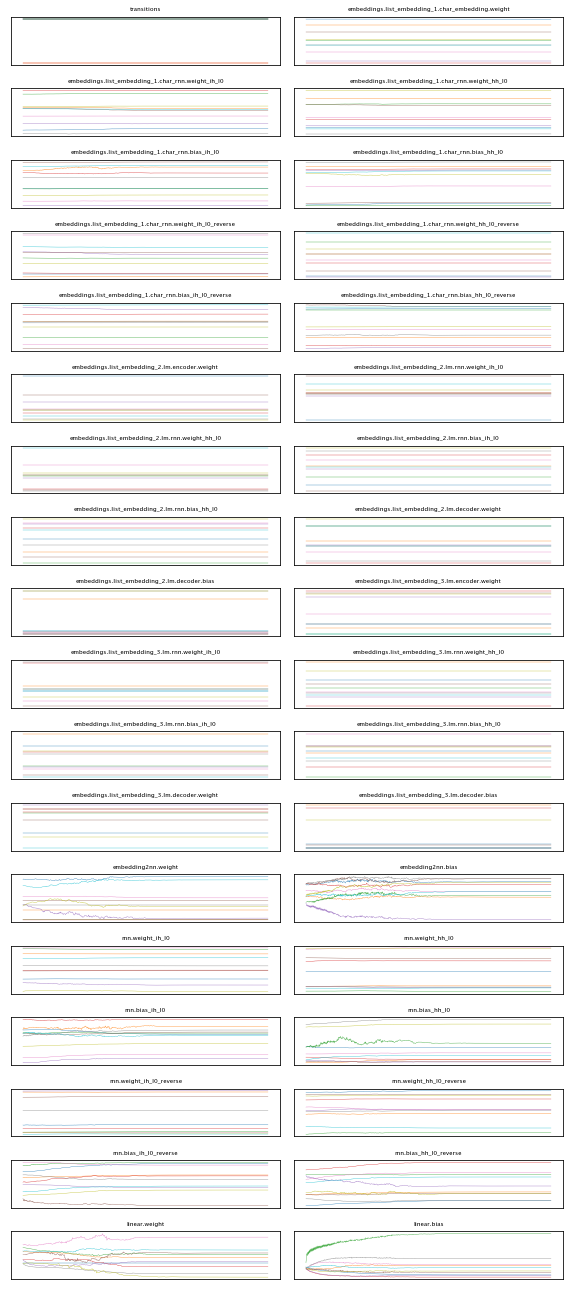

In [212]:
# 2. what tag do we want to predict?
tag_type = 'ner'

# 3. make the tag dictionary from the corpus
tag_dictionary = corpus.make_tag_dictionary(tag_type=tag_type)
print(tag_dictionary)

# 4. initialize embeddings
embedding_types: List[TokenEmbeddings] = [

    WordEmbeddings('glove'),

    # comment in this line to use character embeddings
    CharacterEmbeddings(),

    # comment in these lines to use flair embeddings
    FlairEmbeddings('news-forward-fast'),
    FlairEmbeddings('news-backward-fast')
]

embeddings: StackedEmbeddings = StackedEmbeddings(embeddings=embedding_types)

# 5. initialize sequence tagger
from flair.models import SequenceTagger

tagger: SequenceTagger = SequenceTagger(hidden_size=256,
                                        embeddings=embeddings,
                                        tag_dictionary=tag_dictionary,
                                        tag_type=tag_type,
                                        use_crf=True)

# 6. initialize trainer
from flair.trainers import ModelTrainer

trainer: ModelTrainer = ModelTrainer(tagger, corpus)

# 7. start training
trainer.train('resources/taggers/example-ner',
              learning_rate=0.1,
              mini_batch_size=32,
              max_epochs=150)

# 8. plot weight traces (optional)
from flair.visual.training_curves import Plotter
plotter = Plotter()
plotter.plot_weights('resources/taggers/example-ner/weights.txt')

### Simple model sanity testing

In [217]:
# load the model you trained
model = SequenceTagger.load('resources/taggers/example-ner/final-model.pt')

# create example sentence
sentence = Sentence('The United States of America is very popular on Thursday')

sentence = Sentence('Paris France is too expensive on Monday')

sentence = Sentence('I love Paris in the Spring time')

sentence = Sentence('Los Angeles never sleeps in April')

# predict tags and print
model.predict(sentence)

print(sentence.to_tagged_string())

2020-02-16 14:27:37,965 loading file resources/taggers/example-ner/final-model.pt
Los <I-geo> Angeles <I-geo> never sleeps in April <B-tim>


In [230]:
trainer.final_test(base_path='resources/taggers/example-ner', eval_mini_batch_size=32)

2020-02-16 15:31:10,758 ----------------------------------------------------------------------------------------------------
2020-02-16 15:31:10,759 Testing using best model ...


TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [227]:
!ls 'resources/taggers/example-ner'

best-model.pt  loss.tsv       training.log   weights.txt
final-model.pt test.tsv       weights.png
